<a href="https://colab.research.google.com/github/coffeeboost/CV-traffic-counter/blob/main/traffic_counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install av
!git clone https://github.com/abewley/sort.git
!pip uninstall imgaug
!pip install imgaug==0.4.0
!pip install -r /content/sort/requirements.txt

     |████████████████████████████████| 36.1 MB 267 kB/s 
Cloning into 'sort'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (202/202), 1.21 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 948 kB 6.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.
     |██████████████████

In [ ]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import pprint
from sort import *
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
inst_classes[5]

'airplane'

In [ ]:
import cv2
from IPython.display import clear_output
import numpy as np

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torchvision
# vid = torchvision.io.read_video('/content/gdrive/MyDrive/fixed side of road.mp4') #8 cars
vid = torchvision.io.read_video('/content/gdrive/MyDrive/SEP.30V11_xvid.avi', 0 , 500) #12-13 cars


In [ ]:
frames = vid[0]
device = torch.device("cuda")
frames = frames.to(device)

In [ ]:
frames.shape[0]

501

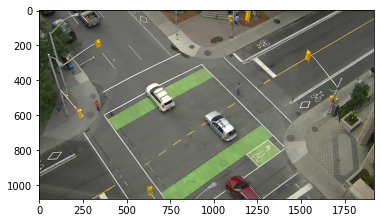

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

def display_frames(frames):
  frames = frames.to('cpu')
  for i in range(0, 500, 10):
    plt.imshow(frames[i])
    plt.show()
    clear_output(wait=True)
    sleep(0.3)
display_frames(frames)

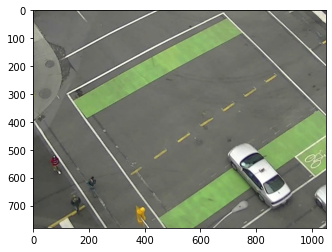

In [ ]:
import torchvision
transform = torchvision.transforms.Compose([
 torchvision.transforms.ToTensor(),
 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
def transform_image(img):
  img = img.permute(2, 0, 1)
  img = img[:,300:12500,250:1300]
  pil_img = torchvision.transforms.ToPILImage()(img)
  norm_img = transform(pil_img)
  return pil_img, norm_img

pil_img, norm_img = transform_image(frames[0])
plt.imshow(pil_img)
plt.show()

In [ ]:
def predict2(img):
  batch = torch.unsqueeze(norm_img, 0)
  with torch.no_grad():
    predictions = model(batch.cuda())[0]
  pprint.pprint(predictions)
  box = predictions['boxes']
  scores = predictions['scores']
  labels = predictions['labels']
  score = scores.reshape(scores.shape[0],1)
  box = torch.cat((box, score), 1)
  
  filter = (scores > 0.1) & (((labels == 3)) | (labels == 10) | (labels == 13) | (labels == 25))
  box = box[filter]
  return box


# pil_img, norm_img = transform_image(frames[0])
# predict2(norm_img)

{'boxes': tensor([[ 452.9890,   21.8426,  723.5016,  186.2908],
        [ 858.9993,  405.3687, 1043.3014,  648.0682],
        [ 665.8508,  331.5078,  729.5642,  372.9981],
        [ 661.5353,  323.6587,  762.3202,  383.2166],
        [ 679.5297,  324.6940,  743.9766,  363.2971],
        [ 619.0538,  336.7777,  746.7221,  412.1844],
        [ 459.3578,  413.3691,  594.3732,  511.0194]], device='cuda:0'),
 'labels': tensor([10, 10, 16, 16, 16, 16, 16], device='cuda:0'),
 'scores': tensor([0.1799, 0.1196, 0.1071, 0.1006, 0.0794, 0.0576, 0.0519],
       device='cuda:0')}


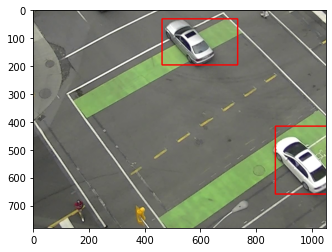

In [ ]:
from sort.sort import Sort
score_threshold = .2
mot_tracker = Sort()
unique = set()
output_img_arr = []
num_frames = frames.shape[0]

for i in range(0, 100, 5):
  pil_img, norm_img = transform_image(frames[i])
  boxes_scores = predict2(norm_img)
  img = np.array(pil_img)
  if boxes_scores is not None:
    tracked_objects = mot_tracker.update(boxes_scores.cpu())
    for x1, y1, x2, y2, obj_id in tracked_objects:
      x1, y1, x2, y2, obj_id = [int(n) for n in [x1, y1, x2, y2, obj_id]]
      unique.add(obj_id)
      cv2.rectangle(img, (x1,y1), (x2,y2), color=(0, 255, 0), thickness=3)

    for x1, y1, x2, y2, score in boxes_scores: #to compare SORT detection ability
      x1, y1, x2, y2, score = [int(n) for n in [x1, y1, x2, y2, score]]
      cv2.rectangle(img, (x1+10,y1+10), (x2+10,y2+10), color=(255, 0, 0), thickness=3)

    output_img_arr.append(img)
    plt.imshow(img)
    plt.show()
    clear_output(wait=True)
    sleep(0.3)
  else:
    mot_tracker.update()


In [ ]:
def arr_to_video_download(arr):
  stack = np.stack(arr, 0)
  torchvision.io.write_video(video_array=stack,fps=26,filename='/content/output.mp4')

arr_to_video_download(output_img_arr)

{'boxes': tensor([[ 46.6200,  86.5641,  94.9161, 103.5102],
        [397.2227, 384.3174, 466.9736, 424.1398],
        [518.4141, 198.7905, 540.0000, 216.8689],
        [ 41.8465, 120.8583, 100.8921, 157.1433],
        [  0.0000,  39.1403, 540.0000, 521.7584],
        [387.6885, 341.8658, 432.7375, 388.5320],
        [488.4529, 200.0601, 540.0000, 238.7431]], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'scores': tensor([0.2445, 0.2381, 0.0633, 0.0608, 0.0573, 0.0561, 0.0507],
       device='cuda:0')}


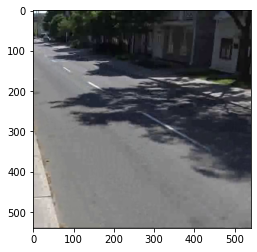

In [ ]:
boxed_arr = []
# from sort.sort import Sort
mot_tracker = Sort()
score_threshold = .3
unique = []

for i in range(0, frames.shape[0], 10):
# for i in range(0,1000,25):
  img = frames[i]
  img = img.permute(2, 0, 1)
  (_, _, _, img, _) = torchvision.transforms.FiveCrop(size=(540,540))(img)
  pil_img = torchvision.transforms.ToPILImage()(img)
  norm_img = transform(pil_img)
  batch = torch.unsqueeze(norm_img, 0)
  with torch.no_grad():
    predictions = model(batch.cuda())[0]
  print(predictions)
  box = predictions['boxes']
  score = predictions['scores'].reshape(predictions['scores'].shape[0],1)
  join_box_score = torch.cat((box, score), 1)
  filtered_box_score = join_box_score[predictions['scores'] > score_threshold]
  filtered_labels = predictions['labels'][predictions['scores'] > score_threshold]
  boxes_scores = filtered_box_score[filtered_labels == 3]

  img = np.array(pil_img)
  if boxes_scores is not None:
    tracked_objects = mot_tracker.update(boxes_scores.cpu())
    for x1, y1, x2, y2, obj_id in tracked_objects:
      unique.append(obj_id)
      x1 =  int(x1)
      y1 =  int(y1)
      x2 =  int(x2)
      y2 =  int(y2)
      obj_id =  int(obj_id)
      cv2.rectangle(img, (x1+10,y1+10), (x2+10,y2+10), color=(0, 255, 0), thickness=3)

    for x1, y1, x2, y2, score in boxes_scores:
      x1 =  int(x1)
      y1 =  int(y1)
      x2 =  int(x2)
      y2 =  int(y2)
      cv2.rectangle(img, (x1,y1), (x2,y2), color=(255, 0, 0), thickness=3)

    plt.imshow(img)
    plt.show()
    clear_output(wait=True)
  else:
    mot_tracker.update()

In [ ]:
num = len(set(unique))
print("number of passing vehicle: ", num)

number of passing vehicle:  7


In [ ]:
score_threshold = .1
box = predictions['boxes']
score = predictions['scores'].reshape(predictions['scores'].shape[0],1)
box_score = torch.cat((box, score), 1)
box_score = box_score[predictions['scores'] > score_threshold]
label_condition = predictions['labels'][predictions['scores'] > score_threshold]
box_score[label_condition == 3][0]

tensor([ 47.6401,  79.5924,  81.6282, 110.9222,   0.5233], device='cuda:0')

In [ ]:
# stack = torch.stack(boxed_arr, 0)
# torchvision.io.write_video(video_array=stack,fps=26,filename='/content/output.mp4')

In [ ]:
# len(boxed_arr) #30 min

# box_label = torch.cat((predictions['boxes'], predictions['labels'].reshape(3,1)), 1)

In [ ]:

  # boxes = predictions['boxes'].type(torch.uint8)
  # pprint.pprint(predictions)
  
  # boxed = torchvision.utils.draw_bounding_boxes(img.cpu(), boxes=predictions['boxes'][predictions['scores'] > score_threshold], width=4, colors='red').permute(1,2,0)
  # boxed_arr.append(boxed)
  # plt.imshow(boxed)